## 卷积神经网络相关程序


#### 1.引言：运用卷积核操作进行图像处理案例

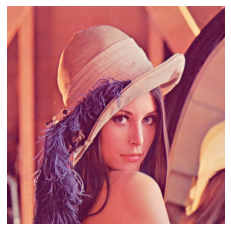

In [4]:
# 引入PIL读取图片，分离RGB三通道
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 读取图片
img = Image.open('lena.png')
plt.axis("off")
plt.imshow(img)

灰度图像：
- 0表示黑
- 255表示白
- 其他数字表示不同的灰度。
- 转换公式：L = R * 299/1000 + G * 587/1000+ B * 114/1000。

(-0.5, 511.5, 511.5, -0.5)

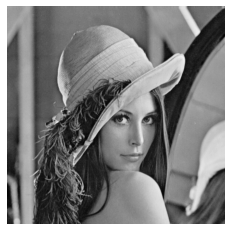

In [5]:
gray = img.convert('L')
plt.figure()
plt.imshow(gray, cmap='gray')
plt.axis('off')

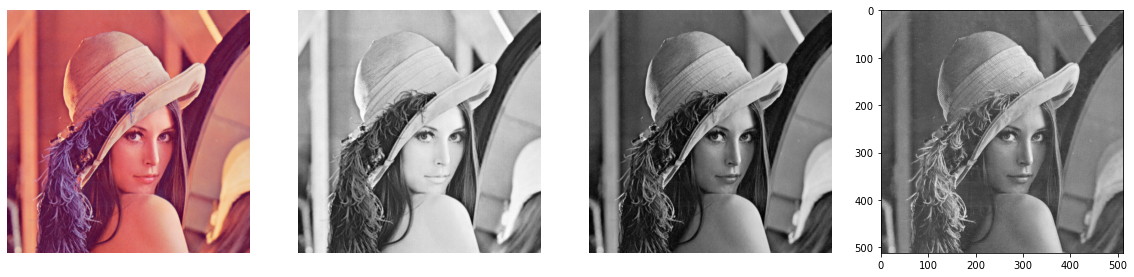

In [6]:
r, g, b = img.split()

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(img)

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(r,cmap='gray')

plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(g,cmap='gray')

plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(b,cmap='gray')

In [7]:
import numpy as np
# 定义卷积函数
def convolution(k, data):
    n,m = data.shape
    img_new = []
    for i in range(n-2):
        line = []
        for j in range(m-2):
            a = data[i:i+3,j:j+3]
            line.append(np.sum(np.multiply(k, a)))
        img_new.append(line)
    return np.array(img_new)

# 对某一通道进行卷积
def transform(channel,k):
    data=np.array(channel)
    n,m=data.shape
    img_new=convolution(k,data)
    return img_new

(512, 512, 3)


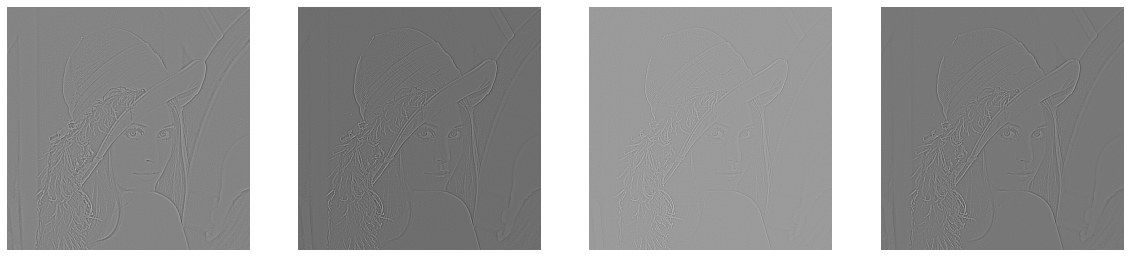

In [8]:
img_array=np.array(img)
print(img_array.shape)

# 定义卷积核（提取边缘特征）
k = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
])

rt=transform(r,k)
gt=transform(g,k)
bt=transform(b,k)

#卷积结果可视化
plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.axis('off')
plt.imshow(rt, cmap='gray')

plt.subplot(1,4,2)
plt.axis('off')
plt.imshow(gt, cmap='gray')

plt.subplot(1,4,3)
plt.axis('off')
plt.imshow(bt, cmap='gray')

plt.subplot(1,4,4)
plt.axis('off')
plt.imshow(rt+gt+bt,cmap='gray')

#### 2.卷积神经网络和传统神经网络的参数对比
通过实验可以发现一个*4层的卷积神经网络*参数量比一个*3层的全连接神经网络*还要少很多参数，而且这个例子中***卷积神经网络最后两层也是全连接层***。

In [9]:
import tensorflow as tf
# 查看参数数量
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

In [10]:
#导入包
from keras import layers
from keras import models

#构建卷积神经网络模型
model=models.Sequential()
# 32个卷积核 所以参数量是（3*3+1）*32，同时32个卷积核，stride为1且不padding情况下，会变成26*26*32的厚度
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))

model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))

#在卷积神经网络模型上添加分类器
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dense (Dense)               (None, 11, 11, 256)       16640     
                                                                 
 dense_1 (Dense)             (None, 11, 11, 10)        2570      
                                                                 
Total params: 38,026
Trainable params: 38,026
Non-trainable params: 0
____________________________________________________

In [11]:
network=models.Sequential()#模型选择sequential
network.add(layers.Dense(256,activation='relu',input_shape=(28*28,)))#256个隐藏节点，激活函数采用relu函数，输入784像素
network.add(layers.Dense(256,activation='relu'))#256个隐藏节点，激活函数采用relu函数，输入784像素
network.add(layers.Dense(10,activation='softmax'))#十个类别，分类函数采用softmax

#编译步骤
network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


### 3.CNN

#### 3.1 一般的CNN

##### 3.1.1 CNN分类图片（cifar10 来自tf库 自制数据集请看第四部分）

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [32]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [33]:
# 归一化处理
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

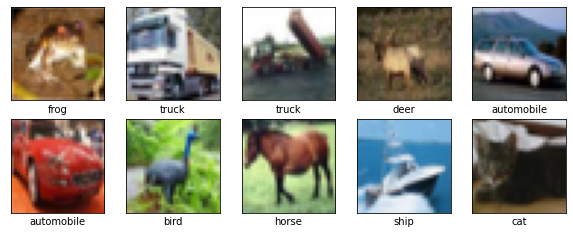

In [34]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
 
# 添加分类器
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_7 (Flatten)         (None, 1024)              0

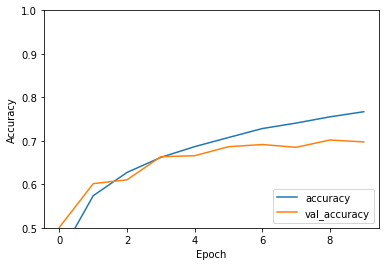

313/313 - 3s - loss: 0.9019 - accuracy: 0.6975 - 3s/epoch - 10ms/step


In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

##### 3.2.2 与传统BP神经网络对比 minist数据集

In [8]:
import numpy
# 引入特殊函数包
import scipy.special


# 神经网络类
class neuralNet:
# 神经网络初始函数
        def __init__(self, inodes, hnodes, onodes, lr):
                # 生成网络对象时候分别初始化输入层，隐藏层，输出层节点的个数
                self.inodes = inodes
                self.hnodes = hnodes
                self.onodes = onodes
                #初始化input和hidden层、hidden层和output层权重，填充在一个均匀分布的随机样本[-0.5,0.5)之间。
                self.wih = numpy.random.rand(self.hnodes, self.inodes)-0.5
                self.who = numpy.random.rand(self.onodes, self.hnodes)-0.5

                # 初始化学习率
                self.lr = lr
                # 使用匿名函数赋值sigmoid函数
                self.sigmoid = lambda x: scipy.special.expit(x)

                # 计数（已经经过几次训练）
                self.num = 0

        # 神经网络训练方法
        def train(self, inputs_list, targets_list):
        # 赋值input矩阵和目标值矩阵
                inputs = numpy.array(inputs_list, ndmin=2).T
                targets = numpy.array(targets_list, ndmin=2).T
        
                # 使用矩阵的乘法运算算出隐藏层的未进行激活函数的值
                hidden_inputs = numpy.dot(self.wih, inputs)
                # 使用激活函数
                hidden_outputs = self.sigmoid(hidden_inputs)

                # 使用矩阵的乘法运算算出输出层未进行激活函数的值
                final_inputs = numpy.dot(self.who, hidden_outputs)
                # 使用激活函数得到最后的输出值
                final_outputs = self.sigmoid(final_inputs)

                # 得到误差（目标值-输出值）
                output_errors = targets-final_outputs
                #我们可以计算出隐含层节点反向传播的误差weights^T·errors
                hidden_errors = numpy.dot(self.who.T, output_errors)
                # 改变隐藏层和输出层的权重
                self.who += self.lr*numpy.dot(output_errors*final_outputs*(1.0-final_outputs), numpy.transpose(hidden_outputs))
                # 改变隐藏层和输入层的权重
                self.wih += self.lr*numpy.dot(hidden_errors*hidden_outputs*(1.0-hidden_outputs), numpy.transpose(inputs))
                # 训练次数++
                self.num += 1
                # 每训练1w次输出提醒
                if self.num % 10000 == 0:
                        print("已经训练", self.num, "张")

        # 给定输入进行输出，就是给定输入，按照普通的矩阵乘法进行输出，用来对训练好的模型进行预测操作，前馈传播就行。
        def query(self, inputs_list):
                inputs = numpy.array(inputs_list, ndmin=2).T

                hidden_inputs = numpy.dot(self.wih, inputs)
                hidden_outputs = self.sigmoid(hidden_inputs)

                final_inputs = numpy.dot(self.who, hidden_outputs)
                final_outputs = self.sigmoid(final_inputs)

                return final_outputs


In [9]:
# 导入minist数据集
from keras.datasets import mnist 
import tensorflow as tf
mnist = tf.keras.datasets.mnist
# 分出测试集和训练集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对测试集和训练集进行归一化处理了
x_train, x_test = x_train / 255.0, x_test / 255.0
# 由于图片为28*28，即784个输入节点，中间层设置200，输出层由于0-9需分10类，所以设置为10了
inodes = 784
hnodes = 200
onodes = 10
# 根据调参设置学习率为0.2
lr = 0.2
# 声明net网络模型并初始化了
net = neuralNet(inodes, hnodes, onodes, lr)
# 根据调参后设置的迭代次数为7
epochs = 7
# 经过7个世代，每个世代训练集的个数n，即训练7n次后
for e in range(epochs):
    for i in range(len(x_train)):
        targets = numpy.zeros(onodes)
        targets[int(y_train[i])] = 1
        net.train(x_train[i].reshape(1,784), targets)

已经训练 10000 张
已经训练 20000 张
已经训练 30000 张
已经训练 40000 张
已经训练 50000 张
已经训练 60000 张
已经训练 70000 张
已经训练 80000 张
已经训练 90000 张
已经训练 100000 张
已经训练 110000 张
已经训练 120000 张
已经训练 130000 张
已经训练 140000 张
已经训练 150000 张
已经训练 160000 张
已经训练 170000 张
已经训练 180000 张
已经训练 190000 张
已经训练 200000 张
已经训练 210000 张
已经训练 220000 张
已经训练 230000 张
已经训练 240000 张
已经训练 250000 张
已经训练 260000 张
已经训练 270000 张
已经训练 280000 张
已经训练 290000 张
已经训练 300000 张
已经训练 310000 张
已经训练 320000 张
已经训练 330000 张
已经训练 340000 张
已经训练 350000 张
已经训练 360000 张
已经训练 370000 张
已经训练 380000 张
已经训练 390000 张
已经训练 400000 张
已经训练 410000 张
已经训练 420000 张


In [10]:
scorecard = []
for i in range(len(x_test)):
    correct_label=y_test[i]
    outputs = net.query(x_test[i].reshape(1,784))
    label = numpy.argmax(outputs)
    print("计算机预测标签：", label, "\n实际：", correct_label)
    if label == correct_label:
        scorecard.append(1)
    else:
        scorecard.append(0)
scorecard_array = numpy.asarray(scorecard)
print("performance = ", scorecard_array.sum() / scorecard_array.size)


计算机预测标签： 7 
实际： 7
计算机预测标签： 2 
实际： 2
计算机预测标签： 1 
实际： 1
计算机预测标签： 0 
实际： 0
计算机预测标签： 4 
实际： 4
计算机预测标签： 1 
实际： 1
计算机预测标签： 4 
实际： 4
计算机预测标签： 9 
实际： 9
计算机预测标签： 5 
实际： 5
计算机预测标签： 9 
实际： 9
计算机预测标签： 0 
实际： 0
计算机预测标签： 6 
实际： 6
计算机预测标签： 9 
实际： 9
计算机预测标签： 0 
实际： 0
计算机预测标签： 1 
实际： 1
计算机预测标签： 5 
实际： 5
计算机预测标签： 9 
实际： 9
计算机预测标签： 7 
实际： 7
计算机预测标签： 3 
实际： 3
计算机预测标签： 4 
实际： 4
计算机预测标签： 9 
实际： 9
计算机预测标签： 6 
实际： 6
计算机预测标签： 6 
实际： 6
计算机预测标签： 5 
实际： 5
计算机预测标签： 4 
实际： 4
计算机预测标签： 0 
实际： 0
计算机预测标签： 7 
实际： 7
计算机预测标签： 4 
实际： 4
计算机预测标签： 0 
实际： 0
计算机预测标签： 1 
实际： 1
计算机预测标签： 3 
实际： 3
计算机预测标签： 1 
实际： 1
计算机预测标签： 3 
实际： 3
计算机预测标签： 4 
实际： 4
计算机预测标签： 7 
实际： 7
计算机预测标签： 2 
实际： 2
计算机预测标签： 7 
实际： 7
计算机预测标签： 1 
实际： 1
计算机预测标签： 2 
实际： 2
计算机预测标签： 1 
实际： 1
计算机预测标签： 1 
实际： 1
计算机预测标签： 7 
实际： 7
计算机预测标签： 4 
实际： 4
计算机预测标签： 2 
实际： 2
计算机预测标签： 3 
实际： 3
计算机预测标签： 5 
实际： 5
计算机预测标签： 1 
实际： 1
计算机预测标签： 2 
实际： 2
计算机预测标签： 4 
实际： 4
计算机预测标签： 4 
实际： 4
计算机预测标签： 6 
实际： 6
计算机预测标签： 3 
实际： 3
计算机预测标签： 5 
实际： 5
计算机预测标签： 5 
实际： 5
计算机预测标签： 6 
实际： 6
计算机预测标签： 0

In [16]:
# 导入minist数据集
from keras.datasets import mnist 
import tensorflow as tf
mnist = tf.keras.datasets.mnist
# 分出测试集和训练集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 对测试集和训练集进行归一化处理了
x_train, x_test = x_train / 255.0, x_test / 255.0
# 由于图片为28*28，即784个输入节点，中间层设置200，输出层由于0-9需分10类，所以设置为10了

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
 
# 添加分类器
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_6 (Flatten)         (None, 576)              

In [18]:
model.save('cnn_normal_net.h5')

#### 3.2 VGG16

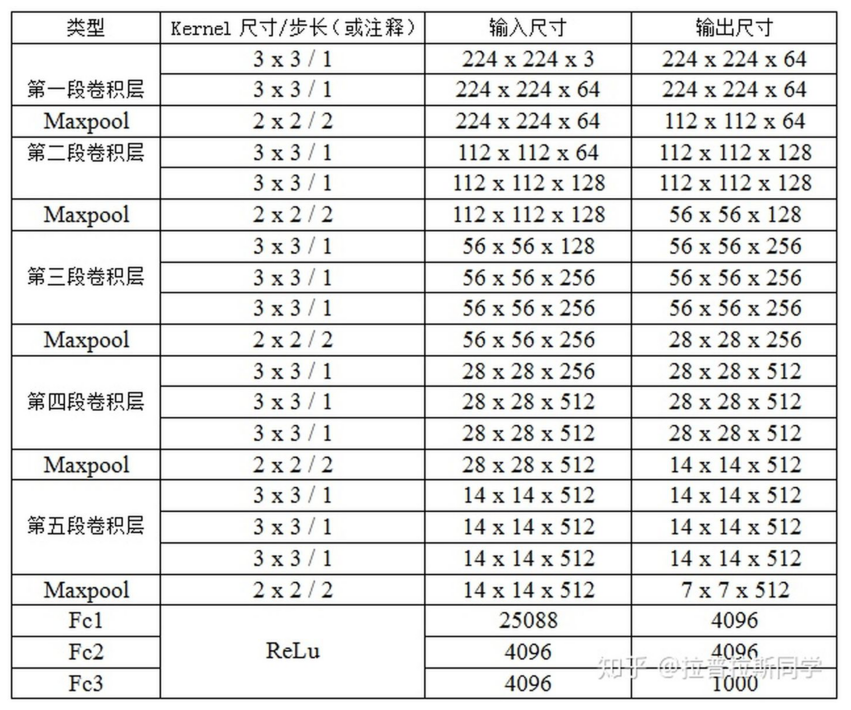

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('42.jpg')
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(img)

In [2]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
import tensorflow as tf

In [12]:
x_shape  = [-1,224,224,3]
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
vgg16 = keras.Sequential(
[
    # Block One
    # 传入（224,224,3）作为输入，filter:卷积器个数为64，padding=same才能输出224*224*64
    layers.Conv2D(input_shape=((x_shape[1], x_shape[2], x_shape[3])),
                 filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block Two
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block Three
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block Four
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(10, activation='softmax')
])
vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
blr = 0.0001
vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=blr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

his_vgg = vgg16.fit(train_vgg_dataset,
                    epochs=10,
                    validation_data=validation_vgg_dataset)


#### 3.3 迁移学习——猫狗分类

In [19]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

In [20]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [21]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory('cats_and_dogs_filtered/train',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [22]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


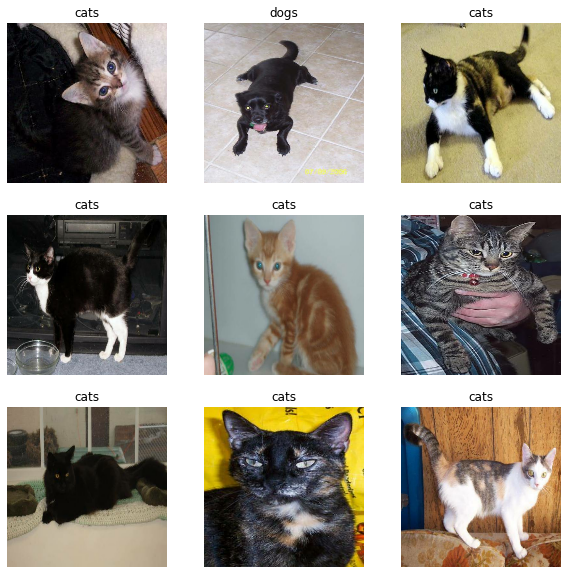

In [23]:
import matplotlib.pyplot as plt
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [25]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

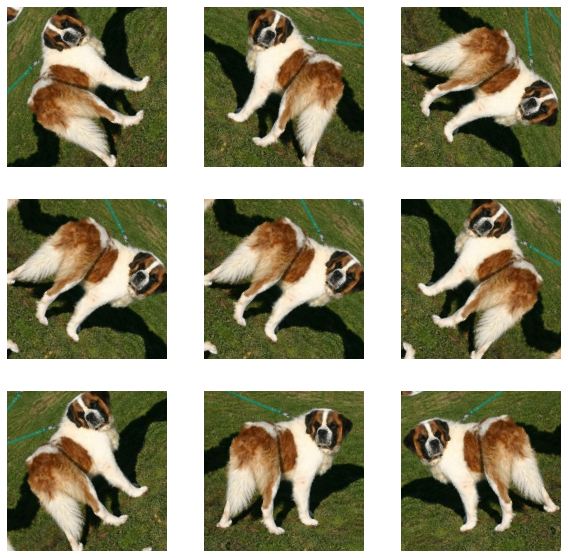

In [28]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [32]:
base_model.trainable = False

In [33]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [36]:
inputs = tf.keras.Input(IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [37]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [38]:
len(model.trainable_variables)

2

In [39]:
initial_epochs = 20
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 19s 607ms/step - loss: 0.7217 - accuracy: 0.5582


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.56


In [41]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 71s 1s/step - loss: 0.6704 - accuracy: 0.6050 - val_loss: 0.4840 - val_accuracy: 0.7030
Epoch 2/20
63/63 [==============================] - 68s 1s/step - loss: 0.5127 - accuracy: 0.7110 - val_loss: 0.3620 - val_accuracy: 0.7834
Epoch 3/20
63/63 [==============================] - 67s 1s/step - loss: 0.4190 - accuracy: 0.7795 - val_loss: 0.2849 - val_accuracy: 0.8589
Epoch 4/20
63/63 [==============================] - 64s 1s/step - loss: 0.3528 - accuracy: 0.8300 - val_loss: 0.2335 - val_accuracy: 0.9010
Epoch 5/20
63/63 [==============================] - 63s 1s/step - loss: 0.3193 - accuracy: 0.8465 - val_loss: 0.2018 - val_accuracy: 0.9109
Epoch 6/20
63/63 [==============================] - 65s 1s/step - loss: 0.2766 - accuracy: 0.8650 - val_loss: 0.1745 - val_accuracy: 0.9344
Epoch 7/20
63/63 [==============================] - 64s 1s/step - loss: 0.2586 - accuracy: 0.8855 - val_loss: 0.1579 - val_accuracy: 0.9431
Epoch 8/20
63/63 [==

In [27]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 14s 518ms/step - loss: 0.1273 - accuracy: 0.9530


In [42]:
model.save('mobileNet20.h5')

D:\DownloadedSoftware\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [33]:
read_model=keras.models.load_model('mobileNet.h5')

In [34]:
read_model.evaluate(validation_dataset)

26/26 [==============================] - 18s 605ms/step - loss: 0.1283 - accuracy: 0.9517


[0.128305584192276, 0.9517326951026917]

### 4.附录：自制数据集

##### 4.1 用opencv处理大小不一的数据图片，统一将图片变为224*224

In [ ]:
import cv2 as cv
import os
import numpy as np


#把cut_img裁成和norm_img形状相同的图片
def cut_photo(H, W, cut_img):  # 设置输出固定形状的图片
    H, W = H, W
    h, w, *c = cut_img.shape
    size = 1 if [] == c else 3  # c是空c=1,其它c=3
    if H / h < W / w:
        img2 = cv.resize(cut_img, (int(w * (H / h)), H), interpolation=cv.INTER_LINEAR)
        _, w, *_ = img2.shape
        left = int((W - w) / 2)
        right = int(np.ceil((W - w) / 2))
        top, bottom = 0, 0
        img2_cut = cv.copyMakeBorder(img2, top, bottom, left, right, cv.BORDER_CONSTANT, value=np.zeros(size))
    else:
        img2 = cv.resize(cut_img, (W, int(h * (W / w))), interpolation=cv.INTER_LINEAR)
        h, _, *_ = img2.shape
        top = int((H - h) / 2)  # 距各边界宽度
        bottom = int(np.ceil((H - h) / 2))
        left, right = 0, 0
        img2_cut = cv.copyMakeBorder(img2, top, bottom, left, right, cv.BORDER_CONSTANT, value=np.zeros(size))
    return img2_cut


def read_photo(H, W, img_path, save_path):
    if not os.path.exists(save_path):  # 如果path存在，返回True；如果path不存在，返回False。
        os.mkdir(save_path)  # 创建目录
    for i, name in enumerate(os.listdir(img_path)):
        filename = os.path.join(img_path, name)
        img = cv.imdecode(np.fromfile(filename, np.uint8), -1)
        cut_img = cut_photo(H, W, img)
        cv.imwrite(os.path.join(save_path, "{}.jpg".format(str(i))), cut_img)


img_path = r"D:/Download/BaiduNetdiskDownload/dog"
save_path = r"./cut_img/dog"
read_photo(224, 224, img_path, save_path)

#### 4.2 给图片合适的命名决定其类别

In [ ]:
import os
path = "cut_img/dog"
filelist = os.listdir(path)
count=0
for file in filelist:
    print(file)
for file in filelist:   
    Olddir=os.path.join(path,file)  
    if os.path.isdir(Olddir):  
        continue
    filename=os.path.splitext(file)[0]   
    filetype=os.path.splitext(file)[1]  
    Newdir=os.path.join(path,"1_"+str(count).zfill(4)+filetype)  
    os.rename(Olddir,Newdir)
 
    count+=1

#### 4.3 将各个照片按照一定比例分为训练集和测试集两个文件夹

In [7]:
# 将一个文件夹下图片按比例分在三个文件夹下
import os
import random
import shutil
from shutil import copy2
datadir_normal = "cut_img/cat"

all_data = os.listdir(datadir_normal)#（图片文件夹）
num_all_data = len(all_data)
print( "num_all_data: " + str(num_all_data) )
index_list = list(range(num_all_data))
#print(index_list)
random.shuffle(index_list)
num = 0

trainDir = "./cut_img/train"#（将训练集放在这个文件夹下）
if not os.path.exists(trainDir):
    os.mkdir(trainDir)
        
testDir = './cut_img/test'#（将测试集放在这个文件夹下）        
if not os.path.exists(testDir):
    os.mkdir(testDir)
        
for i in index_list:
    fileName = os.path.join(datadir_normal, all_data[i])
    if num < num_all_data*0.8:
        copy2(fileName, trainDir)
    else:
        copy2(fileName, testDir)
    num += 1

num_all_data: 2000


##### 4.4 生成图片相应的标签txt

In [ ]:
import os
path = "./cut_img/test" #相应图片所在文件路径
file_list = []
write_file_name = 'cut_img/test/test.txt' #生成的txt文件路径
filelist = os.listdir(path) #该文件夹下所有的文件（包括文件夹）
count=0
write_file = open(write_file_name, "w") #以只写方式打开write_file_name文件
for file in os.listdir(path):   #遍历所有文件

    filename=os.path.splitext(file)[0]  #文件名
    filename_first = os.path.splitext(file)[0][0]
    filetype=os.path.splitext(file)[1]   #文件扩展名
    Newdir = os.path.join(file + ' ' + filename_first )
    file_list.append(Newdir)
    count+=1
number_of_lines = len(file_list)#列表中元素个数
print('file_list1:',file_list)
file_list.sort(key=lambda item:len(str(item)), reverse=False)#排序
print('file_list:',file_list)
print(type(file_list))
for current_line in range(number_of_lines):
    write_file.write(file_list[current_line] + '\n')  # 关闭文件

#### 4.4 划分自制数据集为可以传输到网络的测试集和训练集，并且打乱了顺序并进行了归一化

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os

train_path = 'cut_img/train/'  #存放训练集图片路径
train_txt = 'cut_img/train/train.txt'       #存放的训练集txt标签文件
x_train_savepath = 'x_train.npy'
y_train_savepath = 'y_train.npy'


test_path = 'cut_img/test/'    #存放测试集图片路径
test_txt = 'cut_img/test/test.txt'      #存放的测试集txt标签文件
x_test_savepath = 'x_test.npy'
y_test_savepath = 'y_test.npy'


def generateds(path, txt):
    f = open(txt, 'r')  # 以只读形式打开txt文件
    contents = f.readlines()  # 读取文件中所有行
    f.close()  # 关闭txt文件
    contents=np.array(contents)
    np.random.shuffle(contents)

    x, y_ = [], []  # 建立空列表
    for content in contents:  # 逐行取出
        value = content.split()  # 以空格分开，图片路径为value[0] , 标签为value[1] , 存入列表
        img_path = path + value[0]  # 拼出图片路径和文件名
        img = Image.open(img_path)  # 读入图片
        # img = np.array(img.convert('L'))  # 图片变为8位宽灰度值的np.array格式
        img = np.array(img) / 255.  # 数据归一化 （实现预处理）
        # img = img / 255.  # 数据归一化 （实现预处理）
        x.append(img)  # 归一化后的数据，贴到列表x
        y_.append(value[1])  # 标签贴到列表y_
        print('loading : ' + content)  # 打印状态提示

    x = np.array(x)  # 变为np.array格式
    y_ = np.array(y_)  # 变为np.array格式
    y_ = y_.astype(np.int64)  # 变为64位整型
    return x, y_  # 返回输入特征x，返回标签y_


if os.path.exists(x_train_savepath) and os.path.exists(y_train_savepath) and os.path.exists(
        x_test_savepath) and os.path.exists(y_test_savepath):
    print('-------------Load Datasets-----------------')
    x_train_save = np.load(x_train_savepath)
    y_train = np.load(y_train_savepath)
    x_test_save = np.load(x_test_savepath)
    y_test = np.load(y_test_savepath)
    x_train = np.reshape(x_train_save, (len(x_train_save), 224, 224))
    x_test = np.reshape(x_test_save, (len(x_test_save), 224, 224))
else:
    print('-------------Generate Datasets-----------------')
    x_train, y_train = generateds(train_path, train_txt)
    x_test, y_test = generateds(test_path, test_txt)

    print('-------------Save Datasets-----------------')
    x_train_save = np.reshape(x_train, (len(x_train), -1))
    x_test_save = np.reshape(x_test, (len(x_test), -1))
    np.save(x_train_savepath, x_train_save)
    np.save(y_train_savepath, y_train)
    np.save(x_test_savepath, x_test_save)
    np.save(y_test_savepath, y_test)


In [27]:
import numpy as np
x_test_cnn=np.load('x_test.npy')
y_test_cnn=np.load('y_test.npy')
x_train_cnn=np.load('x_train.npy')
y_train_cnn=np.load('y_train.npy')

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

x_train_array = x_train_cnn.reshape((-1,224,224,3))
x_test_array = x_test_cnn.reshape((-1,224,224,3))
print(x_train_array.shape, ' ', y_train_cnn.shape,type(x_train_array))
print(x_test_array.shape, ' ', y_test_cnn.shape,type(x_test_array))

(2929, 224, 224, 3)   (2929,) <class 'numpy.ndarray'>
(800, 224, 224, 3)   (800,) <class 'numpy.ndarray'>


In [5]:
save_path = './cut_img/'
vgg16.save_weights(save_path)

#### 4.5 训练得到的数据

In [ ]:
import numpy as np
x_test_cnn=np.load('x_test.npy')
y_test_cnn=np.load('y_test.npy')
x_train_cnn=np.load('x_train.npy')
y_train_cnn=np.load('y_train.npy')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

x_train_array = x_train_cnn.reshape((-1,224,224,3))
x_test_array = x_test_cnn.reshape((-1,224,224,3))
print(x_train_array.shape, ' ', y_train_cnn.shape,type(x_train_array))
print(x_test_array.shape, ' ', y_test_cnn.shape,type(x_test_array))

(3200, 224, 224, 3)   (3200,) <class 'numpy.ndarray'>
(800, 224, 224, 3)   (800,) <class 'numpy.ndarray'>


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model_zi = models.Sequential()
model_zi.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_zi.add(layers.MaxPooling2D((2, 2)))
model_zi.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_zi.add(layers.MaxPooling2D((2, 2)))
model_zi.add(layers.Conv2D(64, (3, 3), activation='relu'))
 
# 添加分类器
model_zi.add(layers.Flatten())
model_zi.add(layers.Dense(64, activation='relu'))
model_zi.add(layers.Dense(2))
    
model_zi.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model_zi.fit(x_train_array, y_train_cnn, epochs=10, 
                    validation_data=(x_test_array, y_test_cnn))

Epoch 1/10
100/100 [==============================] - 234s 2s/step - loss: 0.7918 - accuracy: 0.5553 - val_loss: 0.6564 - val_accuracy: 0.6012
Epoch 2/10
100/100 [==============================] - 214s 2s/step - loss: 0.6384 - accuracy: 0.6200 - val_loss: 0.6186 - val_accuracy: 0.6513
Epoch 3/10
100/100 [==============================] - 215s 2s/step - loss: 0.5861 - accuracy: 0.6963 - val_loss: 0.6258 - val_accuracy: 0.6625
Epoch 4/10
100/100 [==============================] - 215s 2s/step - loss: 0.5111 - accuracy: 0.7400 - val_loss: 0.6200 - val_accuracy: 0.6637
Epoch 5/10
100/100 [==============================] - 202s 2s/step - loss: 0.4420 - accuracy: 0.7916 - val_loss: 0.6221 - val_accuracy: 0.6888
Epoch 6/10
100/100 [==============================] - 204s 2s/step - loss: 0.3470 - accuracy: 0.8519 - val_loss: 0.7397 - val_accuracy: 0.6388
Epoch 7/10
100/100 [==============================] - 201s 2s/step - loss: 0.2729 - accuracy: 0.8838 - val_loss: 0.7473 - val_accuracy: 0.6388